### STGAN 이상치 데이터 시각화

In [13]:
import argparse
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# warning 무시
import warnings
warnings.filterwarnings("ignore")

In [7]:
# 데이터 경로 구성
base_dir = base_path = os.path.dirname(os.getcwd())

data_dir = os.path.join(base_dir, "bay/outliers/point_dev0.20-0.50_p0.0100")
data_path = os.path.join(data_dir, "data.npy")
outlier_mask_path = os.path.join(data_dir, "outlier_mask.npy")
time_features_path = os.path.join(data_dir, "time_features.txt")

In [8]:
# 데이터 로드 함수

def load_data(data_path, outlier_mask_path, time_features_path=None):
    """
    데이터 및 이상치 마스크 로드

    Args:
        data_path: 이상치가 포함된 데이터 파일 경로
        outlier_mask_path: 이상치 마스크 파일 경로
        time_features_path: 시간 특성 파일 경로 (선택 사항)

    Returns:
        data: 데이터 배열
        outlier_mask: 이상치 마스크 (True: 정상, False: 이상치)
        time_features: 시간 특성 (제공된 경우)
    """
    print(f"데이터 로드 중: {data_path}")
    data = np.load(data_path)
    outlier_mask = np.load(outlier_mask_path)

    time_features = None
    if time_features_path and os.path.exists(time_features_path):
        time_features = np.loadtxt(time_features_path)

    print(f"데이터 형태: {data.shape}")
    print(f"이상치 마스크 형태: {outlier_mask.shape}")
    if time_features is not None:
        print(f"시간 특성 형태: {time_features.shape}")

    # 이상치 비율 계산
    outlier_ratio = 1.0 - np.mean(outlier_mask)
    print(f"이상치 비율: {outlier_ratio:.4f} ({outlier_ratio*100:.2f}%)")

    return data, outlier_mask, time_features

In [14]:
data, outlier_mask, time_features = load_data(data_path, outlier_mask_path, time_features_path)

데이터 로드 중: /Users/yeseo/DEV/git/Capstone-25-01/STGAN/bay/outliers/point_dev0.20-0.50_p0.0100/data.npy
데이터 형태: (36288, 365, 6, 2)
이상치 마스크 형태: (36288, 365, 6, 2)
시간 특성 형태: (36288, 31)
이상치 비율: 0.0100 (1.00%)


In [10]:
# 시간 정보 추출 함수

def extract_time_info(time_features):
    """
    시간 특성에서 요일 및 시간 정보 추출

    Args:
        time_features: 시간 특성 배열

    Returns:
        day_indices: 요일별 인덱스 사전
        hour_indices: 시간대별 인덱스 사전
    """
    day_names = ["월", "화", "수", "목", "금", "토", "일"]
    day_indices = {}

    # 요일 정보 추출 (첫 7열)
    for day in range(7):
        day_indices[day_names[day]] = np.where(time_features[:, day] == 1)[0]

    # 시간 정보 추출 (다음 24열)
    hour_indices = {}
    for hour in range(24):
        hour_indices[hour] = np.where(time_features[:, hour + 7] == 1)[0]

    return day_indices, hour_indices

In [15]:
# 점 이상치 시각화 함수

def visualize_point_outliers(data, outlier_mask, node_idx=0, feature_idx=0, time_start=0, time_end=200):
    """
    점 이상치 시각화

    Args:
        data: 이상치가 포함된 데이터
        outlier_mask: 이상치 마스크
        node_idx: 시각화할 노드 인덱스
        feature_idx: 시각화할 특성 인덱스
        time_start: 시각화 시작 시간 인덱스
        time_end: 시각화 종료 시간 인덱스
    """
    plt.figure(figsize=(14, 6))

    # 특정 노드, 특성의 시계열 데이터 추출
    time_series = data[time_start:time_end, node_idx, feature_idx, 0]
    mask = outlier_mask[time_start:time_end, node_idx, feature_idx, 0]

    # 정상 데이터와 이상치 구분
    normal_indices = np.where(mask)[0]
    outlier_indices = np.where(~mask)[0]

    # 정상 데이터 플롯
    plt.plot(range(time_start, time_start + len(time_series)), time_series, "b-", alpha=0.7)

    # 이상치 하이라이트
    if len(outlier_indices) > 0:
        plt.scatter(
            time_start + outlier_indices, time_series[outlier_indices], c="red", marker="x", s=100, label="outlier"
        )

    plt.title(f"node {node_idx}, feature {feature_idx} point outlier")
    plt.xlabel("time")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 이상치 비율 및 통계 출력
    outlier_count = len(outlier_indices)
    print(f"\n선택된 시계열 데이터 분석:")
    print(f"- 총 데이터 포인트: {len(time_series)}개")
    print(f"- 이상치 개수: {outlier_count}개 ({outlier_count/len(time_series)*100:.2f}%)")

    if outlier_count > 0:
        print("\n이상치 통계:")
        normal_values = time_series[normal_indices]
        outlier_values = time_series[outlier_indices]
        print(
            f"- 정상 데이터 범위: [{np.min(normal_values):.4f}, {np.max(normal_values):.4f}], 평균: {np.mean(normal_values):.4f}"
        )
        print(
            f"- 이상치 범위: [{np.min(outlier_values):.4f}, {np.max(outlier_values):.4f}], 평균: {np.mean(outlier_values):.4f}"
        )

    return plt.gcf()


선택된 시계열 데이터 분석:
- 총 데이터 포인트: 200개
- 이상치 개수: 1개 (0.50%)

이상치 통계:
- 정상 데이터 범위: [0.0000, 89.0000], 평균: 37.9749
- 이상치 범위: [64.3036, 64.3036], 평균: 64.3036


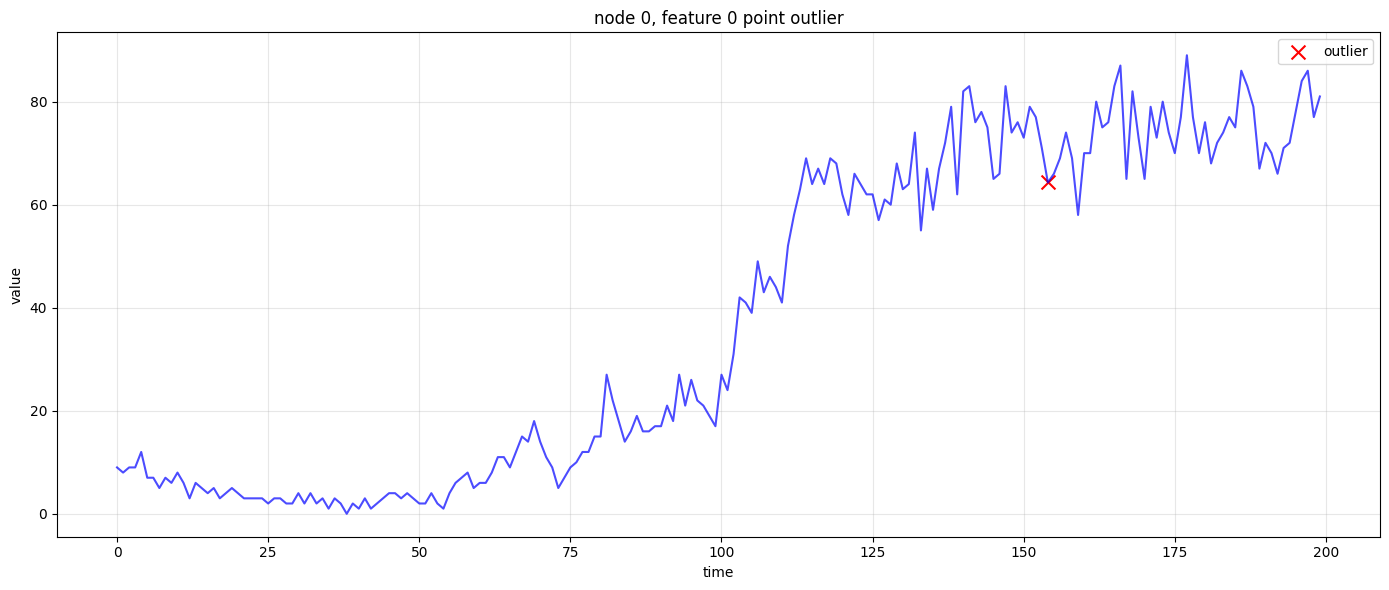

In [16]:
node_idx = 0
feature_idx = 0
time_start = 0
time_end = 200

fig = visualize_point_outliers(
    data,
    outlier_mask,
    node_idx=node_idx,
    feature_idx=feature_idx,
    time_start=time_start,
    time_end=time_end,
)

In [17]:
# 블록 이상치 시각화 함수

def visualize_block_outliers(data, outlier_mask, node_idx=0, feature_idx=0, time_start=0, time_end=500):
    """
    블록 이상치 시각화

    Args:
        data: 이상치가 포함된 데이터
        outlier_mask: 이상치 마스크
        node_idx: 시각화할 노드 인덱스
        feature_idx: 시각화할 특성 인덱스
        time_start: 시각화 시작 시간 인덱스
        time_end: 시각화 종료 시간 인덱스
    """
    plt.figure(figsize=(14, 6))

    # 특정 노드, 특성의 시계열 데이터 추출
    time_series = data[time_start:time_end, node_idx, feature_idx, 0]
    mask = outlier_mask[time_start:time_end, node_idx, feature_idx, 0]

    # 전체 데이터 플롯
    plt.plot(range(time_start, time_start + len(time_series)), time_series, "b-", alpha=0.7)

    # 이상치 블록 시각화
    i = 0
    blocks = []
    while i < len(mask):
        if not mask[i]:  # 이상치 블록 시작
            start = i
            while i < len(mask) and not mask[i]:
                i += 1
            end = i - 1
            blocks.append((start, end))
            plt.axvspan(time_start + start, time_start + end, alpha=0.3, color="red")
        else:
            i += 1

    plt.title(f"node {node_idx}, feature {feature_idx} block outlier")
    plt.xlabel("time")
    plt.ylabel("value")

    # 범례 추가
    from matplotlib.patches import Patch

    legend_elements = [Patch(facecolor="red", alpha=0.3, label="outlier block")]
    plt.legend(handles=legend_elements)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # 블록 정보 출력
    if blocks:
        print("\n이상치 블록 정보:")
        for i, (start, end) in enumerate(blocks):
            duration = end - start + 1
            print(f"- 블록 {i+1}: 시작={time_start + start}, 종료={time_start + end}, 지속 시간={duration}")

    return plt.gcf()

In [18]:
# 맥락 이상치 시각화 함수

def visualize_contextual_outliers(
    data, outlier_mask, time_features, feature_idx=0, day1="월", day2="일", hour1=8, hour2=3
):
    """
    맥락 이상치 시각화 (특정 요일/시간대 비교)

    Args:
        data: 이상치가 포함된 데이터
        outlier_mask: 이상치 마스크
        time_features: 시간 특성 데이터
        feature_idx: 시각화할 특성 인덱스
        day1: 첫 번째 비교 요일
        day2: 두 번째 비교 요일
        hour1: 첫 번째 비교 시간
        hour2: 두 번째 비교 시간
    """
    # 요일 및 시간대 인덱스 추출
    day_indices, hour_indices = extract_time_info(time_features)

    # 특정 요일 및 시간대 인덱스 추출
    day1_hour1_indices = np.intersect1d(day_indices[day1], hour_indices[hour1])
    day2_hour2_indices = np.intersect1d(day_indices[day2], hour_indices[hour2])

    # 특정 노드 선택
    node_idx = 0

    # 평균 프로파일 계산
    day1_hour1_data = data[day1_hour1_indices, node_idx, feature_idx, 0]
    day2_hour2_data = data[day2_hour2_indices, node_idx, feature_idx, 0]

    day1_hour1_mask = outlier_mask[day1_hour1_indices, node_idx, feature_idx, 0]
    day2_hour2_mask = outlier_mask[day2_hour2_indices, node_idx, feature_idx, 0]

    # 이상치 인덱스 찾기
    day1_hour1_outliers = day1_hour1_indices[~day1_hour1_mask]
    day2_hour2_outliers = day2_hour2_indices[~day2_hour2_mask]

    # 시각화
    plt.figure(figsize=(14, 10))

    # 첫 번째 서브플롯: 시간별 비교
    plt.subplot(2, 1, 1)
    plt.plot(day1_hour1_indices, day1_hour1_data, "b-", alpha=0.7, label=f"{day1}d {hour1}h")
    plt.plot(day2_hour2_indices, day2_hour2_data, "g-", alpha=0.7, label=f"{day2}d {hour2}h")

    # 이상치 표시
    if len(day1_hour1_outliers) > 0:
        days1_values = [data[idx, node_idx, feature_idx, 0] for idx in day1_hour1_outliers]
        plt.scatter(day1_hour1_outliers, days1_values, c="red", marker="x", s=100, label=f"{day1}d {hour1}h outlier")

    if len(day2_hour2_outliers) > 0:
        days2_values = [data[idx, node_idx, feature_idx, 0] for idx in day2_hour2_outliers]
        plt.scatter(
            day2_hour2_outliers, days2_values, c="orange", marker="x", s=100, label=f"{day2}d {hour2}h outlier"
        )

    plt.title(f"day and hour comparison (node {node_idx}, feature {feature_idx})")
    plt.xlabel("time index")
    plt.ylabel("value")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 두 번째 서브플롯: 분포 비교
    plt.subplot(2, 1, 2)
    plt.hist(day1_hour1_data, bins=20, alpha=0.5, label=f"{day1}d {hour1}h")
    plt.hist(day2_hour2_data, bins=20, alpha=0.5, label=f"{day2}d {hour2}h")
    plt.title(f"value distribution comparison")
    plt.xlabel("value")
    plt.ylabel("frequency")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()

    # 통계 정보 출력
    print(f"\n맥락 비교 ({day1}요일 {hour1}시 vs {day2}요일 {hour2}시):")
    print(f"- {day1}요일 {hour1}시 데이터 포인트: {len(day1_hour1_data)}개, 이상치: {len(day1_hour1_outliers)}개")
    print(f"- {day2}요일 {hour2}시 데이터 포인트: {len(day2_hour2_data)}개, 이상치: {len(day2_hour2_outliers)}개")

    print(f"\n{day1}요일 {hour1}시 통계:")
    print(
        f"- 범위: [{np.min(day1_hour1_data):.4f}, {np.max(day1_hour1_data):.4f}], 평균: {np.mean(day1_hour1_data):.4f}"
    )

    print(f"\n{day2}요일 {hour2}시 통계:")
    print(
        f"- 범위: [{np.min(day2_hour2_data):.4f}, {np.max(day2_hour2_data):.4f}], 평균: {np.mean(day2_hour2_data):.4f}"
    )

    return plt.gcf()


In [19]:
# 이상치 히트맵 시각화 함수

def visualize_outlier_heatmap(outlier_mask, node_start=0, node_end=30, time_start=0, time_end=200):
    """
    이상치 히트맵 시각화

    Args:
        outlier_mask: 이상치 마스크
        node_start: 시작 노드 인덱스
        node_end: 종료 노드 인덱스
        time_start: 시작 시간 인덱스
        time_end: 종료 시간 인덱스
    """
    plt.figure(figsize=(14, 8))

    # 마스크 선택 (True: 정상, False: 이상치)
    selected_mask = outlier_mask[time_start:time_end, node_start:node_end, 0, 0]

    # 시각화를 위해 반전 (1: 이상치, 0: 정상)
    outlier_pattern = (~selected_mask).astype(int)

    # 히트맵 그리기
    sns.heatmap(outlier_pattern.T, cmap="Reds", cbar_kws={"label": "outlier"})
    plt.title("outlier pattern heatmap")
    plt.xlabel("time")
    plt.ylabel("node ID")
    plt.yticks(np.arange(len(range(node_start, node_end))) + 0.5, labels=range(node_start, node_end))
    plt.xticks(np.arange(0, time_end - time_start, 20) + 0.5, labels=range(time_start, time_end, 20))

    # 이상치 통계
    total_cells = outlier_pattern.size
    outlier_cells = np.sum(outlier_pattern)
    print(f"\n이상치 히트맵 통계:")
    print(f"- 총 셀 수: {total_cells}")
    print(f"- 이상치 셀 수: {outlier_cells} ({outlier_cells/total_cells*100:.2f}%)")

    return plt.gcf()


이상치 히트맵 통계:
- 총 셀 수: 6000
- 이상치 셀 수: 55 (0.92%)


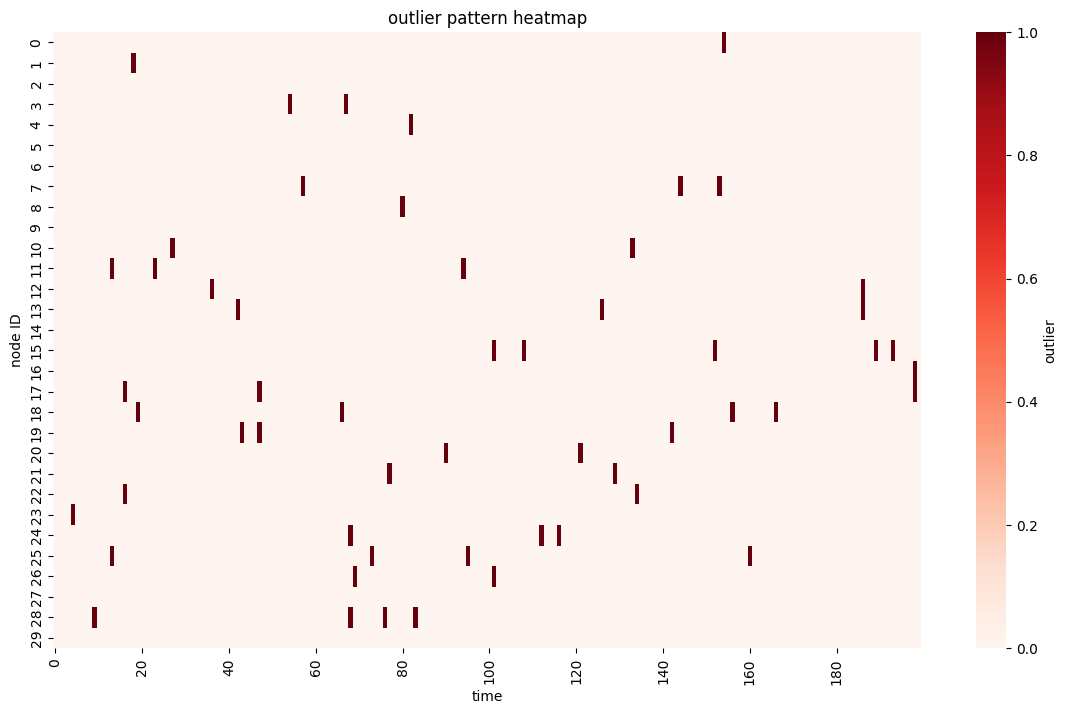

In [20]:
node_start = 0
node_end = 30
time_start = 0
time_end = 200

# 이상치 히트맵 시각화
fig = visualize_outlier_heatmap(
    outlier_mask,
    node_start=node_start,
    node_end=node_end,
    time_start=time_start,
    time_end=time_end,
)

In [ ]:
# 메인 함수

def main(args):
    try:
        # 데이터 경로 구성
        data_dir = args.data_dir
        data_path = os.path.join(data_dir, "data.npy")
        outlier_mask_path = os.path.join(data_dir, "outlier_mask.npy")
        time_features_path = os.path.join(data_dir, "time_features.txt")

        # 데이터 로드
        data, outlier_mask, time_features = load_data(data_path, outlier_mask_path, time_features_path)

        # 시나리오에 따른 시각화
        output_dir = args.output_dir
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)

        if args.scenario == "point":
            # 점 이상치 시각화
            fig = visualize_point_outliers(
                data,
                outlier_mask,
                node_idx=args.node_idx,
                feature_idx=args.feature_idx,
                time_start=args.time_start,
                time_end=args.time_end,
            )
            if output_dir:
                fig.savefig(os.path.join(output_dir, "point_outliers.png"), dpi=300)

        elif args.scenario == "block":
            # 블록 이상치 시각화
            fig = visualize_block_outliers(
                data,
                outlier_mask,
                node_idx=args.node_idx,
                feature_idx=args.feature_idx,
                time_start=args.time_start,
                time_end=args.time_end,
            )
            if output_dir:
                fig.savefig(os.path.join(output_dir, "block_outliers.png"), dpi=300)

        elif args.scenario == "contextual":
            # 맥락 이상치 시각화 (요일 및 시간대 비교)
            if time_features is not None:
                fig = visualize_contextual_outliers(
                    data,
                    outlier_mask,
                    time_features,
                    feature_idx=args.feature_idx,
                    day1=args.day1,
                    day2=args.day2,
                    hour1=args.hour1,
                    hour2=args.hour2,
                )
                if output_dir:
                    fig.savefig(os.path.join(output_dir, "contextual_outliers.png"), dpi=300)
            else:
                print("맥락 이상치 시각화를 위해 시간 특성(time_features.txt) 데이터가 필요합니다.")

        # 이상치 히트맵 시각화
        fig = visualize_outlier_heatmap(
            outlier_mask,
            node_start=args.node_start,
            node_end=args.node_end,
            time_start=args.time_start,
            time_end=args.time_end,
        )
        if output_dir:
            fig.savefig(os.path.join(output_dir, "outlier_heatmap.png"), dpi=300)

        print("모든 시각화가 완료되었습니다.")
        if output_dir:
            print(f"결과가 {output_dir}에 저장되었습니다.")

        plt.show()

    except Exception as e:
        print(f"오류 발생: {str(e)}")
        import traceback

        traceback.print_exc()
        return 1

    return 0

In [ ]:
# 예제 데이터 경로 설정
class Args:
    def __init__(self):
        self.data_dir = "./STGAN/bay/outliers/point_dev0.20-0.50_p0.0100"  # 데이터 디렉토리 경로 설정
        self.output_dir = ""  # 결과를 저장하지 않음
        self.scenario = "point"  # 이상치 시나리오 유형 (point, block, contextual)
        self.node_idx = 0  # 시각화할 노드 인덱스
        self.feature_idx = 0  # 시각화할 특성 인덱스
        self.time_start = 0  # 시각화 시작 시간 인덱스
        self.time_end = 200  # 시각화 종료 시간 인덱스
        self.node_start = 0  # 히트맵 시작 노드 인덱스
        self.node_end = 30  # 히트맵 종료 노드 인덱스
        self.day1 = "월"  # 첫 번째 비교 요일
        self.day2 = "일"  # 두 번째 비교 요일
        self.hour1 = 8  # 첫 번째 비교 시간
        self.hour2 = 3  # 두 번째 비교 시간

# 설정된 Arguments로 main 함수 실행
args = Args()
main(args)